# KFold
- 데이터셋을 K개의 동일 크기 부분(Fold)나눠서 K번 반복하여 하나의 폴드를 검증용으로 사용을 하고 나머지 k-1개의 폴드를 학습용으로 사용
- 모든 폴드를 한번은 검증용으로 포함이 되고 k-1개를 학습용으로 사용 
- 데이터가 수가 적을때 모델의 성능을 안정적으로 평가 할 수 있는 방법 

- 매개변수 
    - n_splits
        - 기본값 : 5
        - 폴드의 개수를 지정 
        - 최소 값은 2
    - shuffle
        - 기본값 : False
        - 데이터를 분할하기 전에 섞을지 지정 
        - True로 변경하게 되면 폴드가 랜덤하게 구성 
    - random_state
        - 기본값 : None
        - shuffle이 True인 경우에 사용
        - 랜덤 시드 고정 
- 속성
    - n_splits 
        - 분할된 폴드의 개수
- 메서드 
    - split(x, y = None)
        - 학습용/검증용 인덱스를 생성
        - 반복문을 이용하여 (train_index, test_index)로 변환하여 사용

- 장점 
    - 데이터를 폴드화 해서 학습/ 검증용으로 사용하기 때문에 데이터가 낭비가 없다. 
    - 일반적으로 사용하던 train_test_split보다 성능 평가가 안정적(설명이 충분하다.)
- 단점 
    - K번의 학습 -> K번의 예측 -> K번의 평가 --> 계산이 늘어남 -> 시간 증가
    - 데이터의 크기가 크다면 시간이 증가 

- 변형 KFold 클래스 
    - StratifiedKFold : 분류 문제에서 클래스의 비율을 유지하여 분할 
    - GroupKFold : 그룹 단위로 데이터를 나눠 그룹이 학습/검증에 동시에 들어가지 않도록 보장 
    - RepeatedKFold : KFold를 여러번 반복해 평가 안정성 강화 

In [2]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, \
                KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, r2_score

In [3]:
# Pipeline + GridSearchCV + KFold를 사용하여 분류 문제 해결 
# iris 데이터를 로드 
iris = pd.read_csv("../data/iris.csv")
iris.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# target 데이터를 0, 1, 2로 데이터를 변경
# iris['target'].unique()
for i, key in enumerate(iris['target'].unique()):
    # print(i)
    # print(key)
    iris['target'] = iris['target'].replace(key, i)

C:\Users\ekfla\AppData\Local\Temp\ipykernel_6480\188653885.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  iris['target'] = iris['target'].replace(key, i)


In [5]:
# train, test 데이터셋을 구분 
x = iris.drop('target', axis=1).values
y = iris['target'].values


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, random_state=42, test_size=0.2, stratify=y
)

In [7]:
# KFold를 이용해서 데이터 분할 
# 분류 모델 -> target의 비율 1:1:1 -> 비율을 맞춰서 폴드화
# stratifiedKFold를 이용
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
cv_folds

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [9]:
# Pipeline 생성 -> 
# 학습(fit()) -> Scaler 생성하고 fit()을 이용하여 범위를 지정하고 
# transform()을 이용해서 스케일링을 하고 모델에 학습을 시킨다.
# 예측(predict()) -> 생성된 Scaler를 사용하여 
# 검증 데이터를 transform()을 이용해서 스케일링하고 학습된 모델에 
# predict() 함수를 이용하여 예측값을 반환
pipe = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('svc', SVC(probability=True, random_state=42))
    ]
)

In [10]:
# GridSearchCV에서 사용할 파라미터 조합을 생성 
# pipeline을 이용하여 Grid를 사용하면 매개변수의 이름을 수정할 필요가 있다
# pipeline에서 사용할 모델에( 이름 + __ + 매개변수명) 키 값들을 변경 
params = {
    "svc__C" : [0.1, 1, 10], 
    'svc__gamma' : ['scale', 'auto'], 
    'svc__kernel' : ['linear', 'rbf']
}

In [11]:
grid_cls = GridSearchCV(
    estimator= pipe,   # gird에서 사용할 모델은 pipeline으로 만들어진 모델
    param_grid= params, # dict 형태로 각 파라미터별 사용할 값 지정
    scoring= 'accuracy',    # 검증할때마다 정확도를 이용하여 모델을 평가
    cv = cv_folds,      # 교차 검증은 횟수는 KFold의 값들을 이용
    verbose = 1,        # 진행상황을 간단한 로그로 표시 
    refit = True,       # 베스트 파라미터를 이용하여 재학습 
    return_train_score= True,   # 학습 데이터의 성능을 확인
    n_jobs=-1           # 해당 코드를 이용하여 작업시 사용할 코어는 모두
)
grid_cls.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [12]:
print(grid_cls.score(X_test, Y_test))

0.9333333333333333


In [13]:
# print(grid_cls.cv_results_)
pd.DataFrame(grid_cls.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003444,0.000583,0.001584,0.000793,0.1,scale,linear,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",0.958333,1.000000,...,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
2,0.003041,0.001009,0.001622,0.001031,0.1,auto,linear,"{'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__ke...",0.958333,1.000000,...,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
6,0.003528,0.001438,0.001103,0.000919,1.0,auto,linear,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.000000,1.000000,...,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
4,0.002289,0.000839,0.001855,0.001047,1.0,scale,linear,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,1.000000,...,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
8,0.003285,0.000386,0.000675,0.000852,10.0,scale,linear,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",1.000000,0.958333,...,0.966667,0.031180,5,0.979167,0.958333,0.968750,0.989583,1.000000,0.979167,0.014731
9,0.002767,0.000359,0.002067,0.001397,10.0,scale,rbf,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.958333,0.958333,...,0.966667,0.016667,5,0.989583,0.979167,0.968750,0.989583,1.000000,0.985417,0.010623
5,0.003309,0.001049,0.001585,0.000793,1.0,scale,rbf,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.958333,1.000000,...,0.966667,0.016667,5,0.979167,0.979167,0.968750,0.979167,0.979167,0.977083,0.004167
7,0.003452,0.000731,0.000071,0.000143,1.0,auto,rbf,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",0.958333,1.000000,...,0.966667,0.016667,5,0.979167,0.979167,0.968750,0.979167,0.979167,0.977083,0.004167
10,0.002301,0.000731,0.001603,0.000657,10.0,auto,linear,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",1.000000,0.958333,...,0.966667,0.031180,5,0.979167,0.958333,0.968750,0.989583,1.000000,0.979167,0.014731
11,0.003103,0.001117,0.001203,0.000982,10.0,auto,rbf,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",0.958333,0.958333,...,0.966667,0.016667,5,0.989583,0.979167,0.968750,0.989583,1.000000,0.985417,0.010623


In [14]:
# pipe + kfold + grid를 이용한 회귀 분석 
# csv에 있는 boston 데이터 로드 
boston = pd.read_csv("../csv/boston.csv")

In [15]:
x = boston.drop('Price', axis=1).values
y = boston['Price']

In [16]:
# train, test 나눌때 회귀 분석이기때문에 계층화 사용하지 않음
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, random_state= 42, test_size=0.2
)

In [17]:
# 폴드화에서도 계층화가 필요 없기때문에 KFold 사용
cv_folds = KFold(n_splits=5, shuffle = True, random_state=42)

In [18]:
pipe_reg = Pipeline(
    [
        ('stdscaler', StandardScaler()), 
        ('svm_reg', SVR())
    ]
)

In [19]:
# SVR() 모델의 파라미터를 C는 [1, 10, 100]
# kenrle은 ['rbf', 'linear]
# epsilon은 [0.1, 0.2, 0.5]
# 파라미터 조합 
params_reg = {
    "svm_reg__C" : [1, 10, 100], 
    "svm_reg__kernel" : ['rbf', 'linear'], 
    "svm_reg__epsilon" : [0.1, 0.2, 0.5]
}

In [20]:
# GridSearchCV를 이용하여 최적화 파라미터를 확인 
# scoring은 'neg_mean_squared_error'
grid_reg = GridSearchCV(
    estimator= pipe_reg, 
    param_grid= params_reg, 
    scoring='neg_mean_squared_error', 
    cv = cv_folds, 
    verbose= 1, 
    refit = True, 
    return_train_score=True
)
grid_reg.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,"Pipeline(step...reg', SVR())])"
,param_grid,"{'svm_reg__C': [1, 10, ...], 'svm_reg__epsilon': [0.1, 0.2, ...], 'svm_reg__kernel': ['rbf', 'linear']}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


#PCA (주성분 분석)
- 차원 축소 기법 중 하나
- 고차원 데이터(피쳐 개수가 많은 데이터)를 상관관계가 없는 새로운 축으로 변환 
- 데이터의 분산을 최대한 보존하면서 차원을 줄여서 시각화

- 매개변수 
    - n_components
        - 기본값 : None
        - 주성분의 개수 또는 비율 설정 
        - None -> 모든 주성분 유지 
        - int -> 선택할 주성분의 개수
        - float(0~1) -> 누적 설명 분산 비율을 기준으로 필요한 주성분의 개수를 선택 
        - "mle" -> 자동으로 최적 차원 수 측정 ( 샘플의 개수 < 피쳐의 개수 인 경우에만 사용이 가능 ) 
    - whiten
        - 기본값 : False
        - 주성분 백터를 단위 분산으로 정규화을 할지 지정
        - 데이터의 정규화 효과 ( 일부 모델에서는 사용가능 )
    - svd_solver
        - 기본값 : "auto"
        - 분해 방식 지정 
        - "auto" : 데이터의 크기에 따라서 자동 선택 
        - "full" : 정확한 SVD 계산 (적은 데이터를 사용)
        - "arpack" : 최소 행렬 기반 (큰 차원에서 작은 주 성분을 추출 할때 유용)
        - "randomized" : 확률적 근사 알고리즘(대규모 데이터에서 유용)
    
- 속성 
    - components_
        - 선택된 주성분 벡터 
    - explained_variance_
        - 각 주성분이 설명하는 분산 값
    - expained_variance_ratio_
        - 각 주성분이 설명하는 분산의 비율
        - 합계가 1에 가까울수록 원래 분산을 잘 보존
    - singular_values_
        - 선택된 주성분에 대응하는 특이값
    - noise_variance_
        - 유지하는 않은 차원에서의 분산 추정치 
- 메서드 
    - fit(x, y)
        - 주성분을 학습 
    - transform(x)
        - 학습된 주성분 축을 기준으로 하여 새로운 데이터 변환 
    - fit_transform(x, y)
        - PCA 학습 + 변환 
    - get_covaiance()
        - PCA로 추정된 공분산 행렬 반환
    - get_precision()
        - PCA로 추정된 정밀도 해영 반환
    

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [22]:
x = iris.drop('target', axis=1).values
y = iris['target'].values

In [23]:
# PCA 객체 생성
pca = PCA()
x_pca = pca.fit_transform(x)

In [24]:
pca_df = pd.DataFrame(x_pca)
df = pd.concat( [pca_df , pd.DataFrame(x) ] , axis=1)
df.head()

,0,1,2,3,0,1,2,3
0,-2.684207,0.326607,-0.021512,0.001006,5.1,3.5,1.4,0.2
1,-2.715391,-0.169557,-0.203521,0.099602,4.9,3.0,1.4,0.2
2,-2.889820,-0.137346,0.024709,0.019305,4.7,3.2,1.3,0.2
3,-2.746437,-0.311124,0.037672,-0.075955,4.6,3.1,1.5,0.2
4,-2.728593,0.333925,0.096230,-0.063129,5.0,3.6,1.4,0.2


In [25]:
# 설명된 분산의 비율 출력 
exlained_var_ratio = pca.explained_variance_ratio_
exlained_var_ratio

array([0.92461621, 0.05301557, 0.01718514, 0.00518309])

In [26]:
# 분산의 비율을 누적합 분산의 비율을 생성 
cum_var_ratio = np.cumsum(exlained_var_ratio)
cum_var_ratio

array([0.92461621, 0.97763178, 0.99481691, 1.        ])

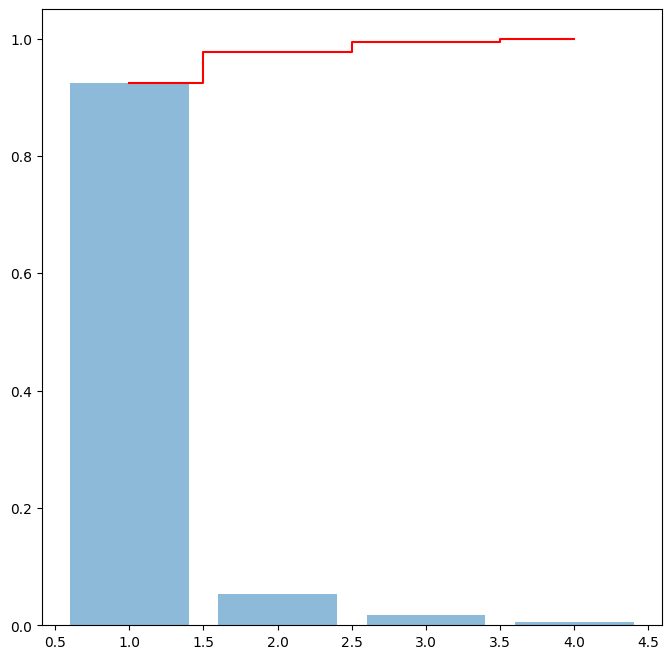

In [27]:
# 분산의 비율을 그래프 시각화
plt.figure(figsize=(8, 8))

plt.bar(
    range(1, len(exlained_var_ratio) + 1 ), exlained_var_ratio, 
    alpha = 0.5, 
)
plt.step(
    range(1, len(cum_var_ratio) + 1), cum_var_ratio, 
    color = 'red', where='mid'
)

plt.show()

- 막대 -> 각 주성분이 설명하는 분산의 비율
- 선 -> 누적 분산의 비율
- 일반적으로 누적 분산의 비율이 90% ~ 95% 이상이 되는 지점까지의 주성분만 선택하는 경우가 다수 -> 차원 축소 근거 

- 이 그래프를 보고 iris 데이터에서는 보통 2개의 주성분 만으로도 데이터의 분산의 대부분인 95%을 설명이 가능하다.  

In [28]:
# 독립 / 종속
x = iris.drop('target', axis=1).values
y = iris['target']

# train, test 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
# KFold를 사용하여 폴드화 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline 생성 -> Scaler, PCA, SVC
pipe = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('pca', PCA(random_state=42)), 
        ('svc', SVC(random_state=42, probability=True))
    ]
)

# 최적의 파라미터를 찾기 위한 조합 
params = {
    "pca__n_components" : [None, 2, 3], 
    "svc__C" : [0.1, 1, 10], 
    "svc__gamma" : ['scale', 'auto'], 
    "svc__kernel" : ['linear', 'rbf']
}

# GridSearchCV 사용 
grid = GridSearchCV(
    estimator= pipe, 
    param_grid= params, 
    scoring= 'accuracy', 
    cv = cv, 
    n_jobs= -1, 
    verbose= 1, 
    refit = True
)

# grid에 fit() 함수를 사용
grid.fit(X_train, Y_train)

print('Best esitimator :', grid.best_estimator_)
print('Best parameter : ', grid.best_params_)
print(classification_report(Y_test, grid.predict(X_test)))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best esitimator : Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42)),
                ('svc',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])
Best parameter :  {'pca__n_components': None, 'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [30]:
pd.DataFrame(grid.cv_results_).sort_values(
    "mean_test_score", ascending=False)[
        [ 'mean_fit_time', 'params', 'mean_test_score']
    ]

,mean_fit_time,params,mean_test_score
0,0.003678,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
2,0.002711,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
6,0.002452,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
4,0.003467,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
24,0.003424,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
26,0.003519,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
28,0.003088,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
29,0.004144,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
8,0.003663,"{'pca__n_components': None, 'svc__C': 10, 'svc...",0.966667
9,0.003606,"{'pca__n_components': None, 'svc__C': 10, 'svc...",0.966667
